In [2]:
# modules
import os
import sys
import numpy as np
import pandas as pd
import multiprocessing as mp
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

sys.path.append('../')
from baseModels.SVM.model import SVM
from ensemble.model import Ensemble

In [4]:
X1 = np.random.rand(3,2)

In [5]:
X1

array([[0.25912286, 0.39379832],
       [0.32468393, 0.74724571],
       [0.60384247, 0.14165171]])

In [6]:
X2 = np.random.rand(2,2)

In [ ]:
X2

In [2]:
class Base:
    def __init__(self,SVM=True,GBC=False,NN=False,pca_components=45,regCparam=30,
        kernparam='rbf',nestparam=250,lrateparam=0.01,mdepthparam=5,ssampleparam=1,hlayer=(50,10),
        lrateinit=0.01,regparam=0.1,random_seed=None,optimizeQ=False,verboseQ=False):
        
        self.pca_components=pca_components
        self.optimizeQ=optimizeQ
        self.verboseQ=verboseQ
        self.rs=random_seed
        
        if SVM:
            self.regCparam=regCparam
            self.kernparam=kernparam
            
        elif GBC:
            self.nestparam=nestparam
            self.lrateparam=lrateparam
            self.mdepthparam=mdepthparam


        elif NN:
            self.hlayer=hlayer
            self.lrateparam=lrateinit
            self.reg=regparam

            
        else:
            raise ValueError('No model initiated')
            
    def get_SVM(self,Xtrain,Xtest,ytrain,ytest):
        return SVM(Xtrain,Xtest,ytrain,ytest,pca_comp=self.pca_components,regC=self.regCparam,kern=self.kernparam,optimize=self.optimizeQ,verbose=self.verboseQ,random_seed=self.rs)
    
    def get_GBC(self,Xtrain,Xtest,ytrain,ytest):
        return GBC(Xtrain,Xtest,ytrain,ytest,pca_comp=self.pca_components,nest=self.nestparam,lrate=self.lrateparam,mdepth=self.mdepthparam,optimize=self.optimizeQ,verbose=self.verboseQ,random_seed=self.rs)

    def get_NN(self,Xtrain,Xtest,ytrain,ytest):
        return NN(Xtrain,Xtest,ytrain,ytest,pca_comp=self.pca_components,hlayers=self.hlayer,lrateinit=self.lrateparam,regparam=self.reg,optimize=self.optimizeQ,verbose=self.verboseQ,random_seed=self.rs)


class TEClassification(Base):
    
    def __init__(self,enzseqdata,testenzseqdata,labelfile,trainfeaturefiledirs,testfeaturefiledirs,model='SVM',random_seed=None,pca_components=55,n_models=17,validation_fraction=0.25):
        
        self.random_seed = random_seed
        self.model=model
        self.default_pca_components = pca_components
        self.n_models = n_models
        self.validation_fraction = validation_fraction
        
        
        #initialize super class
        if self.model=='SVM':
            super().__init__(optimizeQ=False)
        else:
            if self.model=='GBC':
                super().__init__(SVM=False,GBC=True)
            elif self.model=='NN':
                super().__init__(SVM=False,NN=True)
            else:
                raise ValueError('Wrong Model Assigned')
        
        self.object_map = {'SVM':self.get_SVM,'NN':self.get_NN,'GBC':self.get_GBC}
        
        # original data based on which everything is obtained
        df1 = pd.read_csv(enzseqdata,header=None)
        df2 = pd.read_csv(labelfile,header=None)
        self.train_df = df1.merge(df2,on=0)
        
        self.enz_names = self.train_df[0].values
        self.X = self.train_df.iloc[:,1].values
        self.y = self.train_df.iloc[:,-1].values
        
        # training and testing data for general use
        self.X_train, self.X_valid, self.y_train, self.y_valid,self.enz_train,self.enz_valid = train_test_split(self.X, self.y,self.enz_names, test_size=self.validation_fraction, random_state=self.random_seed)
        
        self.label_file = labelfile
        
        #generate a list of names from the directories
        trainfeatfiles = [d+f.name for d in trainfeaturefiledirs for f in os.scandir(d) if f.name.endswith('.csv.gz')]
        self.featnames = [f.name.replace('.csv.gz','') for d in trainfeaturefiledirs for f in os.scandir(d) if f.name.endswith('.csv.gz')]
        
        # getting all SVM objects together
        self.objects = list(map(self.get_model_feat,trainfeatfiles))

        
        # select only the best models based on training
        self.best_idx,self.best_models = self.select_top_models(self.objects)
        self.best_model_names = np.array(self.featnames)[self.best_idx]
        
        # getting all model predictions together
        self.all_model_preds = [o.ypredtest for o in self.best_models]
        self.en = Ensemble(self.all_model_preds,self.y_valid)
        self.precision = precision_score(self.y_valid,self.en.preds,labels=[3],average='micro')
        
        pass
    
    
    def get_model_feat(self,featfilename):
        df1 = pd.read_csv(featfilename,header=None)
        df2 = pd.read_csv(self.label_file,header=None)
        df_feat = df1.merge(df2,on=0).set_index(0)
        df_feat_train = df_feat.loc[self.enz_train]
        df_feat_valid = df_feat.loc[self.enz_valid]
        X_train_feat,y_train_feat = df_feat_train.iloc[:,0:-1].values,df_feat_train.iloc[:,-1].values
        X_valid_feat,y_valid_feat = df_feat_valid.iloc[:,0:-1].values,df_feat_valid.iloc[:,-1].values

        if X_train_feat.shape[1]<self.default_pca_components:
            self.pca_components = int(0.75*X_train_feat.shape[1])
        else:
            self.pca_components=self.default_pca_components
        
        obj = self.object_map[self.model](X_train_feat,X_valid_feat,y_train_feat,y_valid_feat)
        return obj
        
    def select_top_models(self,Os):
        o_valid_accs = [o.acc_train for o in Os]
        sorted_idx = np.argsort(o_valid_accs)[::-1]
        best_idx = sorted_idx[:self.n_models]
        return best_idx,np.array(Os)[best_idx]
        

In [3]:
%%time
if __name__=='__main__':
    # Sequence and label files 
    enz_file = '../data/SeqFile/EnzymeSequence.csv'
    label_file = '../data/LabelFiles/EnzymeLabelsMultiClass.csv'

    # Feature dir for iFeature,kernel,pssm 
    ifeatdatadir = '../featEngg/ifeatMethods/data/featvec/'
    kerneldatadir = '../featEngg/kernelMethods/data/featvec/'
    pssmdatadir = '../featEngg/pssmMethods/data/featvec/'
    trainfeatdirs = [ifeatdatadir,kerneldatadir,pssmdatadir]


    te = TEClassification(enz_file,None,label_file,trainfeatdirs,None,random_seed=7)
    
#     def multi_func(rs):
#         te_i = TEClassification(enz_file,label_file,featdirs,random_seed=rs)
#         return te_i.precision,te_i.en.acc    
    
#     pool = mp.Pool(mp.cpu_count())

    
    
    
#     metrics = list(pool.map(multi_func,range(100)))
    


CPU times: user 6.12 s, sys: 132 ms, total: 6.25 s
Wall time: 6.27 s


In [4]:
te.best_model_names

array(['dp_pssm', 'pse_pssm', 's_fpssm', 'CTDC', 'rpm_pssm',
       'gappyKernel', 'spectrumKernel', 'pssm_composition', 'CKSAAGP',
       'TPC', 'GDPC', 'GTPC', 'DPC', 'DDE', 'PAAC', 'APAAC', 'CKSAAP'],
      dtype='<U24')

In [5]:
te.en.acc

0.7241379310344828

In [6]:
te.precision

0.6923076923076923

In [9]:
te.best_model_names

array(['dp_pssm', 'pse_pssm', 's_fpssm', 'CTDC', 'rpm_pssm',
       'gappyKernel', 'spectrumKernel', 'pssm_composition', 'CKSAAGP',
       'TPC', 'GDPC', 'GTPC', 'DPC', 'DDE', 'PAAC', 'APAAC', 'CKSAAP'],
      dtype='<U24')

In [6]:
te.best_model_names

array(['mismatchKernel', 'spectrumKernel', 'DDE', 'DPC', 'TPC',
       'gappyKernel', 'CKSAAP', 'KSCTriad', 'Geary', 'NMBroto', 'CTriad',
       's_fpssm', 'CKSAAGP', 'Moran', 'GTPC', 'SOCNumber', 'aac_pssm'],
      dtype='<U24')

In [4]:
prec = [metr[0] for metr in metrics]
accs = [metr[1] for metr in metrics]

In [5]:
print(min(prec),np.mean(prec),max(prec),np.std(prec))

0.4 0.8647021571106052 1.0 0.09289527542039411


In [6]:
print(min(accs),np.mean(accs),max(accs),np.std(accs))

0.4827586206896552 0.7785758620689656 1.0 0.07104290467315877


In [7]:
def saveResults(filename):
    with open('../data/SimResults/EnsembleResults/'+filename,'w') as f:
        for rs,score in enumerate(metrics):
            f.write(str(rs)+','+str(score[0])+','+str(score[1])+'\n')
    return

In [8]:
saveResults('MultiClassEnsemble.csv')

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([   4.,    9.,   28.,  121.,  342.,  835., 1689., 2309., 3050.,
        1613.]),
 array([0.4 , 0.46, 0.52, 0.58, 0.64, 0.7 , 0.76, 0.82, 0.88, 0.94, 1.  ]),
 <BarContainer object of 10 artists>)

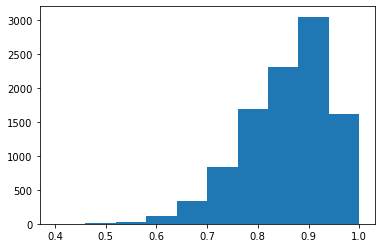

In [10]:
plt.hist(prec)

(array([  11.,   91.,  202.,  431., 2158., 1751., 3613., 1072.,  641.,
          30.]),
 array([0.48275862, 0.53448276, 0.5862069 , 0.63793103, 0.68965517,
        0.74137931, 0.79310345, 0.84482759, 0.89655172, 0.94827586,
        1.        ]),
 <BarContainer object of 10 artists>)

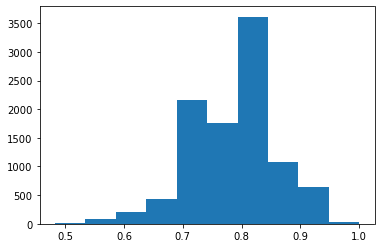

In [11]:
plt.hist(accs)

In [12]:
np.median(accs),np.median(prec)

(0.7931034482758621, 0.8666666666666667)